#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [ ]:
!pip install matplotlib pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pymorphy2
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 75.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=b26aa45ca67c7ac50bba09a33a72f87d5e7ab4725327d5e77b0991eb78c7782e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

In [ ]:
!pip install pymystem3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import json
import gensim
from gensim.models import Word2Vec

from pymystem3 import Mystem
m = Mystem()

import gzip

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:

1) добавьте лемматизацию в предобработку (любым способом)

2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window используется не так и вам нужно это  изменить!)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [ ]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]

    # ЛЕММАТИЗАЦИЯ
    lemmas = []
    for token in tokens:
        result = morph.parse(token)
        lemmas.append(result[0].normal_form)

    return lemmas

In [ ]:
f = open('wiki_data.txt', encoding = 'utf-8')
data = f.read()
lines = data.split('\n')

In [ ]:
#%%time

#vocab = Counter()

#for line in lines:
#    vocab.update(preprocess(line))

# просто было интересно, ибо это было долго с:

In [ ]:
# захотелось сохранить словарь в файл,
# чтобы потом не собирать его заново с:

#with open('vocab.json', 'w+', encoding='utf-8') as file:
#    json.dump(vocab, file)

In [ ]:
f_vocab = open('vocab.json', encoding='utf-8')
vocab = json.load(f_vocab)

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
#%%time

#sentences = []

#for line in lines:
#    tokens = preprocess(line)
#    if not tokens:
#        continue
#    ids = [word2id[token] for token in tokens if token in word2id]
#    sentences.append(ids)

CPU times: user 16min 33s, sys: 1.98 s, total: 16min 35s
Wall time: 16min 47s


In [ ]:
# и это тоже в файл,
# потому что это тоже долго с:

#with open('sentences.json', 'w+', encoding='utf-8') as file:
#    json.dump(sentences, file)

In [ ]:
f_sentences = open('sentences.json', encoding='utf-8')
sentences = json.load(f_sentences)

In [ ]:
vocab_size = len(id2word)
# >>> 12550
#round(len(sentences)/2)
# >>> 10001

In [ ]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

**1. CBOW:**

In [ ]:
# размер окна = Nслов слева + Nслов справа
# здесь window = N

def gen_batches_cbow(sentences, window = 3, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [ ]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_cbow(sentences[:10001], window=3),
          validation_data=gen_batches_cbow(sentences[10001:],  window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 146s 28ms/step - loss: 0.3563 - accuracy: 0.8465 - val_loss: 0.3731 - val_accuracy: 0.8720
Epoch 2/2
5000/5000 [==============================] - 51s 10ms/step - loss: 0.2328 - accuracy: 0.9041 - val_loss: 0.4282 - val_accuracy: 0.8723


In [ ]:
embeddings = model.layers[2].get_weights()[0]

In [ ]:
most_similar('компьютер', embeddings)

['компьютер',
 'приспособление',
 'windows',
 'аксессуар',
 'фильтрация',
 'телефон',
 'аккумулятор',
 'переработка',
 'api',
 'usb']

In [ ]:
most_similar('университет', embeddings)

['университет',
 'институт',
 'академия',
 'колледж',
 'факультет',
 'школа',
 'медицинский',
 'кафедра',
 'преподавать',
 'студент']

*Вполне адекватный подбор слов в обоих случаях!*

**2. Skip Gram:**

In [ ]:
# размер окна = Nслов слева + Nслов справа
# здесь window = N
def gen_batches_sg(sentences, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [ ]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_sg(sentences[:10001], window=6),
          validation_data=gen_batches_sg(sentences[10001:],  window=6),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
10000/10000 [==============================] - 67s 7ms/step - loss: 0.3961 - accuracy: 0.8255 - val_loss: 0.4207 - val_accuracy: 0.8222
Epoch 2/3
10000/10000 [==============================] - 65s 7ms/step - loss: 0.3943 - accuracy: 0.8262 - val_loss: 0.4742 - val_accuracy: 0.8022
Epoch 3/3
10000/10000 [==============================] - 65s 6ms/step - loss: 0.4087 - accuracy: 0.8221 - val_loss: 0.4164 - val_accuracy: 0.8260


In [ ]:
embeddings = model.layers[2].get_weights()[0]

In [ ]:
most_similar('компьютер', embeddings)

['компьютер',
 'встроить',
 'интерфейс',
 'графический',
 'windows',
 'поддерживаться',
 'приложение',
 'пользователь',
 'мобильный',
 'движок']

In [ ]:
most_similar('университет', embeddings)

['университет',
 'факультет',
 'профессор',
 'преподавать',
 'бакалавр',
 'колледж',
 'академия',
 'преподаватель',
 'философия',
 'институт']

*Тоже вполне адекватные результаты, похожие на предыдущие*

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [ ]:
#%%time
#texts = [preprocess(line) for line in lines]

CPU times: user 16min 26s, sys: 2.33 s, total: 16min 28s
Wall time: 16min 33s


In [ ]:
# и это тоже в файл,
# потому что это тоже долго !!!

#with open('texts.json', 'w+', encoding='utf-8') as file:
#    json.dump(texts, file)

In [ ]:
f_texts = open('texts.json', encoding='utf-8')
texts = json.load(f_texts)

**1. Word2Vec**

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300,
                             min_count=60,
                             max_vocab_size=11000,
                             window=7,
                             epochs=5,
                             hs=0,
                             negative=3,
                             ns_exponent=0.80,
                             sample=1e-4)

CPU times: user 32.4 s, sys: 278 ms, total: 32.7 s
Wall time: 20.1 s


In [ ]:
w2v.wv.most_similar('ученик')

[('учитель', 0.8902589082717896),
 ('читать', 0.7700539827346802),
 ('живопись', 0.760702908039093),
 ('учиться', 0.7570605278015137),
 ('преподавать', 0.7206429839134216),
 ('математика', 0.7201995849609375),
 ('врач', 0.7163223028182983),
 ('преподаватель', 0.7095030546188354),
 ('пение', 0.707107663154602),
 ('мальчик', 0.7052708864212036)]

In [ ]:
w2v.wv.most_similar('книга')

[('сборник', 0.8541963696479797),
 ('опубликовать', 0.8254109621047974),
 ('стихотворение', 0.80225670337677),
 ('стих', 0.8010192513465881),
 ('издание', 0.7991791367530823),
 ('написать', 0.798490047454834),
 ('автор', 0.79310142993927),
 ('издать', 0.7928077578544617),
 ('рассказ', 0.7901987433433533),
 ('публикация', 0.7580052614212036)]

*Получился довольно адекватный подбор слов, ура-ура!*

**2. FastText**

In [ ]:
%%time
ft = gensim.models.FastText(texts, min_n=2, max_n=7)

CPU times: user 6min 23s, sys: 1.19 s, total: 6min 24s
Wall time: 3min 41s


In [ ]:
ft.wv.most_similar('ученик')

[('соученик', 0.9119221568107605),
 ('учебник', 0.9097641706466675),
 ('мученик', 0.9056090116500854),
 ('«ученик', 0.8704502582550049),
 ('новомученик', 0.841926097869873),
 ('великомученик', 0.8270666599273682),
 ('учитель', 0.8189818263053894),
 ('воспитанник', 0.8161504864692688),
 ('учёный-медик', 0.8003951907157898),
 ('щеник', 0.7974719405174255)]

In [ ]:
ft.wv.most_similar('книга')

[('книгами»', 0.8910693526268005),
 ('«книга', 0.8907877802848816),
 ('книга»', 0.8665858507156372),
 ('книги»', 0.8624141216278076),
 ('аудиокнига', 0.829254686832428),
 ('«автобиография', 0.7088160514831543),
 ('«рассказ', 0.6947526335716248),
 ('биография', 0.692071259021759),
 ('«записка', 0.6908115744590759),
 ('библиография', 0.6788958311080933)]

*у FT, в силу своих особенностей, конечно совсем другие наборы; с учетом его опоры на символьные нграммы и возможности генерировать векторы для слов, которых нет в словаре, выбор слов вполне объяснимый*

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [ ]:
data = pd.read_csv('labeled.csv')

In [ ]:
data['norm_text'] = data.comment.apply(preprocess)

In [ ]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд-то, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежать, и, ныть, ..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кто, любить, гоблин, тупорылый, что-ли, ил..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть, утомлённый, солнце, 2, и, оказать..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушать, правило, раздел, т.к, в,..."


In [ ]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6308

In [ ]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=15)

Epoch 1/15
428/428 [==============================] - 50s 105ms/step - loss: 0.6120 - accuracy: 0.6650 - val_loss: 0.5713 - val_accuracy: 0.6768
Epoch 2/15
428/428 [==============================] - 14s 33ms/step - loss: 0.5136 - accuracy: 0.7301 - val_loss: 0.4782 - val_accuracy: 0.7323
Epoch 3/15
428/428 [==============================] - 7s 16ms/step - loss: 0.4147 - accuracy: 0.8352 - val_loss: 0.4020 - val_accuracy: 0.8460
Epoch 4/15
428/428 [==============================] - 5s 12ms/step - loss: 0.3486 - accuracy: 0.8744 - val_loss: 0.3646 - val_accuracy: 0.8821
Epoch 5/15
428/428 [==============================] - 5s 12ms/step - loss: 0.3064 - accuracy: 0.8937 - val_loss: 0.3366 - val_accuracy: 0.8752
Epoch 6/15
428/428 [==============================] - 4s 8ms/step - loss: 0.2770 - accuracy: 0.9041 - val_loss: 0.3233 - val_accuracy: 0.8752
Epoch 7/15
428/428 [==============================] - 3s 6ms/step - loss: 0.2522 - accuracy: 0.9152 - val_loss: 0.3139 - val_accuracy: 0.886

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


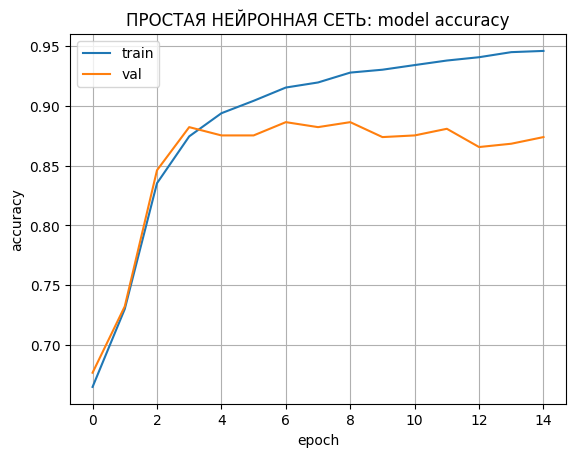

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('ПРОСТАЯ НЕЙРОННАЯ СЕТЬ: model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid ( True )
plt.show()

**эмбединги Word2Vec**

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts + data['norm_text'].values.tolist(), window=6, epochs=5)

CPU times: user 1min 8s, sys: 292 ms, total: 1min 9s
Wall time: 45 s


In [ ]:
weightsw2v = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weightsw2v[i] = w2v.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то рандомный вектор
        continue
        weightsw2v[i] = w2v.wv['йцукенгш']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100,
                                       trainable=True,
                                       weights=[weightsw2v])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 33s 76ms/step - loss: 0.6035 - accuracy: 0.6579 - val_loss: 0.5627 - val_accuracy: 0.6755
Epoch 2/30
428/428 [==============================] - 9s 20ms/step - loss: 0.5310 - accuracy: 0.7014 - val_loss: 0.4961 - val_accuracy: 0.7379
Epoch 3/30
428/428 [==============================] - 5s 11ms/step - loss: 0.4637 - accuracy: 0.7888 - val_loss: 0.4379 - val_accuracy: 0.8294
Epoch 4/30
428/428 [==============================] - 4s 9ms/step - loss: 0.4081 - accuracy: 0.8387 - val_loss: 0.3960 - val_accuracy: 0.8627
Epoch 5/30
428/428 [==============================] - 4s 10ms/step - loss: 0.3658 - accuracy: 0.8659 - val_loss: 0.3660 - val_accuracy: 0.8682
Epoch 6/30
428/428 [==============================] - 3s 8ms/step - loss: 0.3338 - accuracy: 0.8832 - val_loss: 0.3468 - val_accuracy: 0.8710
Epoch 7/30
428/428 [==============================] - 3s 6ms/step - loss: 0.3083 - accuracy: 0.8920 - val_loss: 0.3317 - val_accuracy: 0.8835
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


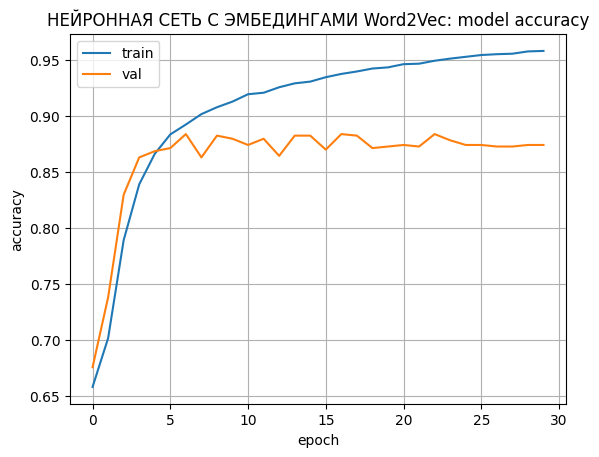

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('НЕЙРОННАЯ СЕТЬ С ЭМБЕДИНГАМИ Word2Vec: model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid ( True )
plt.show()

**эмбединги FastText**

In [ ]:
%%time
ft = gensim.models.FastText(texts + data['norm_text'].values.tolist(), window=6, epochs=5)

CPU times: user 5min 58s, sys: 1.22 s, total: 6min
Wall time: 3min 29s


In [ ]:
weightsft = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weightsft[i] = ft.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то рандомный вектор
        continue
        weightsft[i] = ft.wv['йцукенгш']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100,
                                       trainable=True,
                                       weights=[weightsft])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 33s 74ms/step - loss: 0.6177 - accuracy: 0.6563 - val_loss: 0.5810 - val_accuracy: 0.6810
Epoch 2/30
428/428 [==============================] - 11s 25ms/step - loss: 0.5587 - accuracy: 0.6868 - val_loss: 0.5308 - val_accuracy: 0.7254
Epoch 3/30
428/428 [==============================] - 5s 11ms/step - loss: 0.5069 - accuracy: 0.7482 - val_loss: 0.4844 - val_accuracy: 0.7781
Epoch 4/30
428/428 [==============================] - 4s 10ms/step - loss: 0.4586 - accuracy: 0.7999 - val_loss: 0.4440 - val_accuracy: 0.7975
Epoch 5/30
428/428 [==============================] - 4s 8ms/step - loss: 0.4177 - accuracy: 0.8333 - val_loss: 0.4129 - val_accuracy: 0.8294
Epoch 6/30
428/428 [==============================] - 3s 6ms/step - loss: 0.3840 - accuracy: 0.8527 - val_loss: 0.3882 - val_accuracy: 0.8460
Epoch 7/30
428/428 [==============================] - 3s 8ms/step - loss: 0.3558 - accuracy: 0.8701 - val_loss: 0.3678 - val_accuracy: 0.8655


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


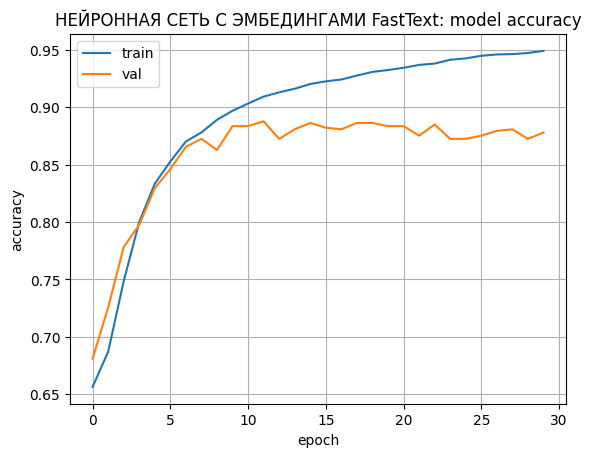

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('НЕЙРОННАЯ СЕТЬ С ЭМБЕДИНГАМИ FastText: model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid ( True )
plt.show()

*Если судить по графикам, то последний вариант (с эмбедингами Fast Text) показывает самый лучший результат из проверенных*

**Rus-vectores**

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('ruscorpora_upos_skipgram_300_5_2018.vec.gz', binary=False)

In [ ]:
model.most_similar('асфальт_NOUN')

[('брусчатка_NOUN', 0.7214363813400269),
 ('мостовая_NOUN', 0.6998396515846252),
 ('тротуар_NOUN', 0.6851969361305237),
 ('асфальт_VERB', 0.6842679977416992),
 ('мостовая_ADJ', 0.6654257774353027),
 ('асфальтовый_ADJ', 0.6630223393440247),
 ('укатывать_ADJ', 0.6569754481315613),
 ('поребрик_NOUN', 0.6558485627174377),
 ('асфальт_PROPN', 0.6554470062255859),
 ('заасфальтировать_VERB', 0.6396544575691223)]

In [ ]:
mapping ={'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [ ]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [ ]:
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']